In [1]:
from dotenv import load_dotenv

load_dotenv()

False

In [26]:
from typing import Literal
from langchain_core.messages import HumanMessage
from langgraph.graph import END, START, StateGraph, MessagesState
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode


# Define a tool for weather information
@tool
def get_weather(location: str):
    """Call to get the current weather."""
    if location.lower() in ["munich"]:
        return "It's 15 degrees Celsius and cloudy."
    else:
        return "It's 32 degrees Celsius and sunny."


tools = [get_weather]
model = ChatOpenAI(model="gpt-4o-mini").bind_tools(tools)


def call_model(state: MessagesState):
    messages = state["messages"]
    response = model.invoke(messages)
    return {"messages": [response]}


def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END


subgraph_workflow = StateGraph(MessagesState)
tool_node = ToolNode(tools)

subgraph_workflow.add_node("agent", call_model)
subgraph_workflow.add_node("tools", tool_node)
subgraph_workflow.add_conditional_edges("agent", should_continue)
subgraph_workflow.add_edge("tools", "agent")
subgraph_workflow.set_entry_point("agent")

subgraph = subgraph_workflow.compile()

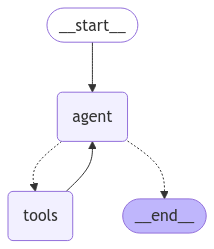

In [27]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        subgraph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [28]:
subgraph.invoke({"messages": [HumanMessage(content="How is the weather in Munich?")]})

{'messages': [HumanMessage(content='How is the weather in Munich?', additional_kwargs={}, response_metadata={}, id='728b163c-48f8-49f7-aea4-a6345e20214d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_FqzgzvHweaWA3mlKMxTWS3Zj', 'function': {'arguments': '{"location":"Munich"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 51, 'total_tokens': 67, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9d7fbb84-830d-4978-8cde-79495c6b85c6-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Munich'}, 'id': 'call_FqzgzvHweaWA3mlKMxTWS3Zj', 'type': 'tool_call'}], usage_metadata={

In [29]:
from typing import TypedDict
from langgraph.graph import StateGraph


# Dummy start node implementation
def start_node(state: MessagesState):
    return state


main_graph = StateGraph(MessagesState)
main_graph.add_node("start", start_node)
main_graph.add_node("subgraph", subgraph)
main_graph.add_edge(START, "start")
main_graph.add_edge("start", "subgraph")

graph = main_graph.compile()

In [11]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

try:
    display(
        Image(
            graph.get_graph().draw_mermaid_png(
                draw_method=MermaidDrawMethod.API,
            )
        )
    )
except Exception:
    pass

In [31]:
initial_state = {"messages": [HumanMessage(content="What's the weather in Munich?")]}
result = graph.invoke(initial_state, subgraphs=False)

In [32]:
result

{'messages': [HumanMessage(content="What's the weather in Munich?", additional_kwargs={}, response_metadata={}, id='4e751382-7a27-43eb-ad41-a04e75830a89'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_GQw15mblpNJiTQe1xI4ttEy5', 'function': {'arguments': '{"location":"Munich"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 50, 'total_tokens': 66, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bd83329f63', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ff7831e6-070e-4d8c-9c0d-042b5f0e7450-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Munich'}, 'id': 'call_GQw15mblpNJiTQe1xI4ttEy5', 'type': 'tool_call'}], usage_metadata={

In [19]:
class MessagesState(TypedDict):
    parent_messages: list[str]


def invoke_subgraph(state: MessagesState):
    subgraph_output = subgraph.invoke({"messages": state["parent_messages"]})
    state["parent_messages"] = subgraph_output["messages"]
    return state


main_graph = StateGraph(MessagesState)
main_graph.add_node("start", start_node)
main_graph.add_node("invoke_subgraph", invoke_subgraph)
main_graph.add_edge(START, "start")
main_graph.add_edge("start", "invoke_subgraph")


graph = main_graph.compile()

In [34]:
initial_state = {
    "parent_messages": [HumanMessage(content="What's the weather in Munich?")]
}
result = graph.invoke(initial_state, subgraphs=False)

InvalidUpdateError: Must write to at least one of ['messages']

In [21]:
result

{'parent_messages': [HumanMessage(content="What's the weather in Munich?", additional_kwargs={}, response_metadata={}, id='2748e949-ea2d-439d-9fb6-5930f3365d3a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_eHfI9NRk26yXnQVjaS4iIYv6', 'function': {'arguments': '{"location":"Munich"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 50, 'total_tokens': 66, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e203eddd-f4c4-4f13-b0cf-94042b51aff6-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Munich'}, 'id': 'call_eHfI9NRk26yXnQVjaS4iIYv6', 'type': 'tool_call'}], usage_met